In [1]:
import gdal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import raster_plot



In [4]:
#Import the data
raster_path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/"
raster = gdal.Open(raster_path + "/Cache_creek_clip.bil")#Get raster data

dem = raster.ReadAsArray()


creek= "Perkins_creek"
path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/Previous_LSDTT_version/Channel_extraction/"+creek+"/" #Set path to data
name = "Cache_creek_clip_fullProfileMC_forced_0.5_20_-4924088_20_90_3010.tree" #Set file name
csv_name = "Cache_creek_clip_fullProfileMC_forced_0.5_20_-4924088_20_90_3010_for_Arc.csv"

## IMPORT DATA for csv or tree files
#for csv files
creek_data = np.genfromtxt((path+csv_name), delimiter=',', skip_header=1, names=['id', 'x', 'y', 'chan_number', 'reciever_chan','node_on_reciever_chan', 'node', 'row','column', 'flow_distance', 'chi', 'elevation', 'drainage_area', 'n_data_points', 'm_mean','m_st_dev', 'm_std_err', 'b_mean', 'b_st_dev', 'b_std_err', 'DW_mean', 'DW_st_dev', 'DW_std_err', 'fitted_elev_mean', 'fitted_elev_stdev', 'fitted_elev_std_err'])
#for tree files
#creek_data = np.genfromtxt((path+name), delimiter=' ', skip_header=1, names=['chan_number', 'reciever_chan','node_on_reciever_chan', 'node', 'row','column', 'flow_distance', 'chi', 'elevation', 'drainage_area', 'n_data_points', 'm_mean','m_st_dev', 'm_std_err', 'b_mean', 'b_st_dev', 'b_std_err', 'DW_mean', 'DW_st_dev', 'DW_std_err', 'fitted_elev_mean', 'fitted_elev_stdev', 'fitted_elev_std_err'])


In [321]:
df = pd.DataFrame(creek_data)

In [356]:
fd_from_junction = df['flow_distance']-df['flow_distance'].min()




<type 'numpy.ndarray'>
<type 'numpy.ndarray'>


In [210]:
#This returns a mesh grid of x and y coordinates to plot up a full raster

def full_raster_xy_generator(raster):

    (upper_left_x, x_res, x_rotation, upper_left_y, y_rotation, y_res) = raster.GetGeoTransform()
    dx = x_res
    dy = y_res
    nx, ny = raster.RasterXSize, raster.RasterYSize  # Size of the original raster

    xllcenter = upper_left_x + dx/2  # x coordinate center of lower left pxl
    yllcenter = upper_left_y - dx/2 # y coordinate center of lower left pxl   - (ny-1)*dx 

    #Create arrays of the x and y coordinates of each pixel (the axes)
    xcoordinates = [x*dx + xllcenter for x in range(nx)]
    ycoordinates = [y*dy + yllcenter for y in range(ny)]

    #Create 2 2d grids describing x and y coordinates
    X,Y = np.meshgrid(xcoordinates, ycoordinates) 


    return X, Y

X,Y = plot_coord(raster)

In [228]:
def raster_subsample_xy_generator(raster, creek_data):
    
    '''
    This function generates and x, y grid of a subsample of a full raster that
    only encompasses the stream of interest. This provides a quick way to analyze
    stream data without clipping rasters
    
    raster is the full raster from: raster = gdal.Open('raster/path').
    
    creek_data contains the x and y coordinates from the creek of interest, 
    should be stored as creek_data['x'] and creek_data['y'].

    x_res and y_res are the resoultions of the raster in x and y dimensions.

    nx_creek and ny_creek are the range of x and y that cover the creek.

    xoff and yoff are the number of pixels to start the plot of the raster.

    xsize and ysize are the range of pixels to plot the raster
    '''

    #Use gdal GetGeoTransorm to get important attributes of the raster
    (upper_left_x, x_res, x_rotation, upper_left_y, y_rotation, y_res) = raster.GetGeoTransform()

    #Define the range of the raster to plot that only covers the creek of interest
    nx_creek = max(creek_data['x']) - min(creek_data['x'])
    ny_creek = max(creek_data['y']) - min(creek_data['y'])
    xoff = ((min(creek_data['x'])-upper_left_x)/x_res).astype(int).item()
    yoff = ((upper_left_y - max(creek_data['y']))/x_res).astype(int).item()
    xsize = (nx_creek/x_res).astype(int).item()
    ysize = (ny_creek/x_res).astype(int).item()

    #Select a part of the raster from the full raster to plot
    array_part = raster.ReadAsArray(
        xoff=xoff,
        yoff=yoff,
        xsize=xsize,
        ysize=ysize)
    ##Can use this to test if the raster section is what you want.
    #plt.imshow(array_part)
    #plt.show()

    #Define the center of the upper left pixel of the creek area
    xcenter = min(creek_data['x']) + x_res/2  
    ycenter = max(creek_data['y']) - y_res/2 
    #Convert pixels into utm coordinates
    xcoordinates = [x*x_res + xcenter for x in range(xsize)]
    ycoordinates = [y*y_res + ycenter for y in range(ysize)]

    #Create a mesh grid of the coordinates for plotting the raster
    X,Y = np.meshgrid(xcoordinates, ycoordinates)
    
    return X, Y


In [230]:
X, Y = raster_subsample_xy_generator(raster, creek_data)


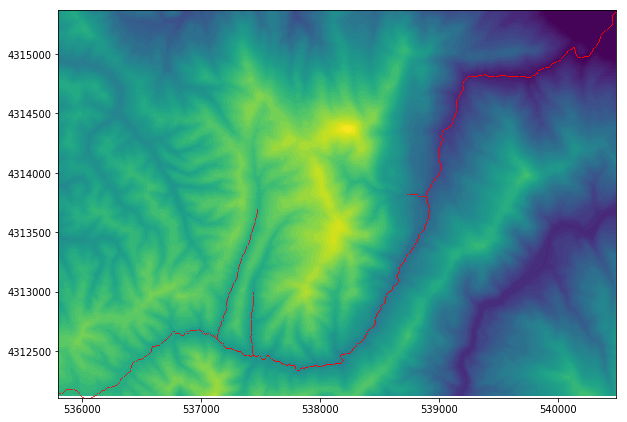

In [231]:
fig, ax = plt.subplots(1, figsize=(10,10), sharex=False) #define 2 subfigures

ax.contourf(X, Y, array_part, levels=np.linspace(np.amin(array_part[array_part > 0]),np.amax(array_part), 50))
ax.plot(creek_data['x'], creek_data['y'], 'ro',  markersize=1, markeredgewidth=0.0)
ax.set_aspect('equal')
plt.show()

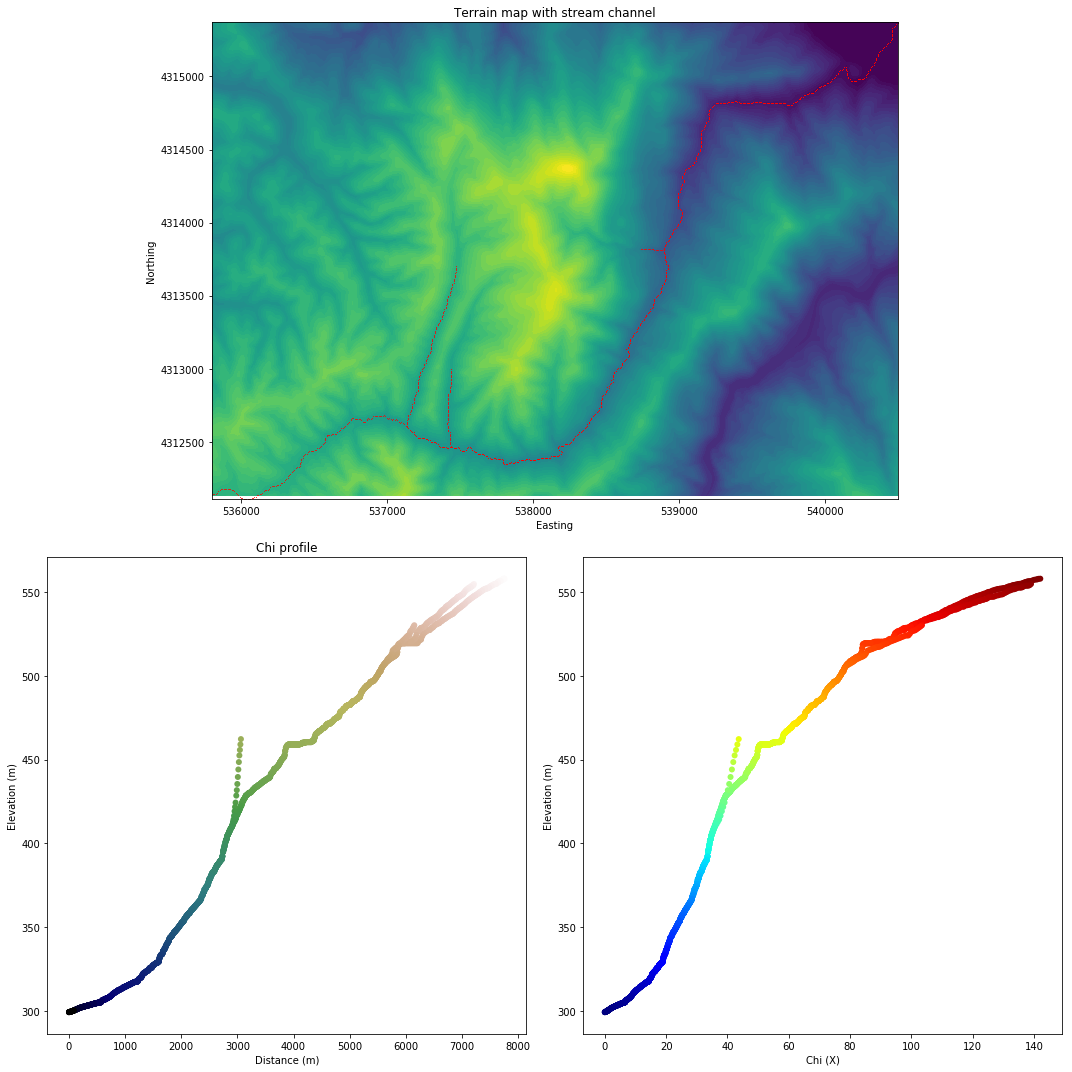

In [414]:
#calculate flow distance from junction
fd_from_junction = creek_data['flow_distance'] - min(creek_data['flow_distance'])


#cm = plt.cm.gist_earth
fig, ax = plt.subplots(figsize=(15,15))

ax1 = plt.subplot(211)
ax2 = plt.subplot(223)#, xlim=[min(fd_from_junction)-100, max(fd_from_junction)+100], ylim=[min(creek_data['elevation'])-50, max(creek_data['elevation'])+50], aspect=10)#, sharey=ax3)#)
ax3 = plt.subplot(224)#,# xlim=[min(creek_data['chi'])-100, max(creek_data['chi'])+100], ylim=[min(creek_data['elevation'])-50, max(creek_data['elevation'])+50], aspect=10)#, sharey=ax3)#)  #,sharey=ax2)

ax1.contourf(X, Y, array_part, levels=np.linspace(np.amin(array_part[array_part > 0]),np.amax(array_part), 50))
ax1.plot(creek_data['x'], creek_data['y'], 'ro',  markersize=1, markeredgewidth=0.0)
ax1.set_aspect('equal')
ax1.set_title('Terrain map with stream channel')
ax1.set_ylabel('Northing')
ax1.set_xlabel('Easting')


ax2.scatter(fd_from_junction, creek_data['elevation'], c=creek_data['elevation'], cmap=cm, edgecolors='none')
#ax2.set_aspect(20)
ax2.set_title('Elevation profile')
ax2.set_ylabel('Elevation (m)')
ax2.set_xlabel('Distance (m)')


ax3.scatter(creek_data['chi'], creek_data['elevation'], c=creek_data['elevation'], cmap=plt.get_cmap("jet"), edgecolors='none')
#ax[2].text(3, 2500, 'm/n = 0.45')
#ax3.set_aspect(0.5)
ax2.set_title('Chi profile')
ax3.set_ylabel('Elevation (m)')
ax3.set_xlabel('Chi (X)')
#ax3.sharey=ax2

plt.tight_layout()

plt.show()